In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum,count,round , lit,when,substring,avg,countDistinct,floor,max,min,percentile_approx

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import locale
import pandas as pd
import plotly.express as px
import time
import os

# Pré-processamento
from pyspark.ml.feature import StringIndexer, OneHotEncoder as OneHotEncoderSpark, VectorAssembler, MinMaxScaler as MinMaxScalerSpark,RobustScaler,VectorAssembler


from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Clusterização Hierárquica
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
# Clusterização K-Means
from sklearn.cluster import KMeans
# Métrica de qualidade de clusters
from sklearn.metrics import silhouette_score


caminho =r'D:/base_ans_parquet/'

anos_filtrar = ["2023", "2024", "2025"]

arquivos_parquet = [
    os.path.join(caminho, f)
    for f in os.listdir(caminho)
    if f.endswith(".parquet") and any(ano in f for ano in anos_filtrar)
]

spark = SparkSession.builder \
    .appName("LeituraParquet") \
    .config("spark.driver.memory", "12g") \
    .config("spark.driver.maxResultSize", "8g") \
    .getOrCreate()
inicio = time.time()

spark.conf.set("spark.sql.execution.pyspark.udf.faulthandler.enabled", "true")

df = spark.read.parquet(*arquivos_parquet)
total_registros = df.count()  # Força leitura e conta registros
fim = time.time()

print(f"Total de registros: {total_registros}")
print(f"Tempo de leitura: {fim - inicio:.2f} segundos")

Total de registros: 421212923
Tempo de leitura: 8.16 segundos


In [2]:
#FILTRAR DADOS
df_soma0 = df.agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_total"))
#df_soma0.show()
#FILTRAR APENAS USUARIOS DE PLANO DE SAUDE, EXCLUIR ODONTOLOGICO 
df_filtrado = df.filter(
    (col("COBERTURA_ASSIST_PLAN") == "Médico-hospitalar")     
)
df_soma = df_filtrado.agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_total"))
#df_soma.show()


#REMOVER USUARIOS SEM FAIXA ETARIA, SEM VINCULO
df_filtrado2345 = df_filtrado.filter(
    (col("DE_FAIXA_ETARIA") != "Informada Incorr") &
    (col("TIPO_VINCULO") != "Não Identificado") &
    (col("SG_UF") != "XX") &
    (col("DE_CONTRATACAO_PLANO") != "Não Identificado")
)
df_soma2 = df_filtrado2345.agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_total"))
#df_soma2.show()

df_filtrado6 = df_filtrado2345.filter(
    col("ID_CMPT_MOVEL").isin("2025-05")
)


df_somagroupby = df_filtrado6.groupBy("DE_FAIXA_ETARIA_REAJ", "TIPO_VINCULO").agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_valor"))

df_filtrado7 = df_filtrado6.filter(
    (col("ID_CMPT_MOVEL")=="2025-05") &
    (col("NM_RAZAO_SOCIAL")=="BRADESCO SAÚDE S.A." ) &
    (col("SG_UF").isin("PR"))
    
)

df_somagroupby.show(200)




+--------------------+------------+----------+
|DE_FAIXA_ETARIA_REAJ|TIPO_VINCULO|soma_valor|
+--------------------+------------+----------+
|        44 a 48 anos|     Titular|   3100206|
|        24 a 28 anos|     Titular|   2723753|
|        39 a 43 anos|  Dependente|   1479903|
|        29 a 33 anos|  Dependente|   1174542|
|        49 a 53 anos|  Dependente|    949867|
|          59 ou mais|  Dependente|   2312193|
|          59 ou mais|     Titular|   6066158|
|        19 a 23 anos|     Titular|   1593692|
|        39 a 43 anos|     Titular|   3621862|
|        24 a 28 anos|  Dependente|   1072228|
|        54 a 58 anos|  Dependente|    769314|
|         0 a 18 anos|  Dependente|  10023029|
|        44 a 48 anos|  Dependente|   1275434|
|        54 a 58 anos|     Titular|   1896262|
|         0 a 18 anos|     Titular|   1886454|
|        29 a 33 anos|     Titular|   3196199|
|        19 a 23 anos|  Dependente|   1576341|
|        34 a 38 anos|     Titular|   3489900|
|        49 a

In [3]:
qtde=df_filtrado7.count()
print ({qtde})

{23204}


In [5]:
# 4. Selecionar colunas numéricas e categóricas
col_numericas = [
    "QT_BENEFICIARIO_ATIVO",
    "QT_BENEFICIARIO_ADERIDO",
    "QT_BENEFICIARIO_CANCELADO"
]
col_categoricas = [
    "TIPO_VINCULO",
    "DE_FAIXA_ETARIA",
    "TP_SEXO",
    "DE_CONTRATACAO_PLANO"
]


# Atualizar lista de colunas escalonadas
col_numericas_scaled = [f"{col}_scaled" for col in col_numericas]

# 5. StringIndexer + OneHotEncoder para cada coluna categórica
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx") for col in col_categoricas]

# OneHotEncoder para múltiplas colunas (PySpark 4.0)
encoder = OneHotEncoderSpark(
    inputCols=[f"{col}_idx" for col in col_categoricas],
    outputCols=[f"{col}_vec" for col in col_categoricas],
    handleInvalid="keep"
)

# Pipeline de transformação
pipeline = Pipeline(stages=indexers + [encoder])
df_encoded = pipeline.fit(df_filtrado7).transform(df_filtrado7)

# Junta tudo num vetor de features
input_features = col_numericas + [f"{col}_vec" for col in col_categoricas]
assembler = VectorAssembler(inputCols=input_features, outputCol="features_raw")
df_vector = assembler.transform(df_encoded)

# Escalona com MinMaxScaler
scaler = MinMaxScalerSpark(inputCol="features_raw", outputCol="features_scaled")
#robust_scaler = RobustScaler(inputCol="features_raw", outputCol="features_scaled")

df_scaled = scaler.fit(df_vector).transform(df_vector)

# Coleta os dados como vetores NumPy para clusterização fora do Spark
X = df_scaled.select("features_scaled").rdd.map(lambda row: row["features_scaled"].toArray()).collect()


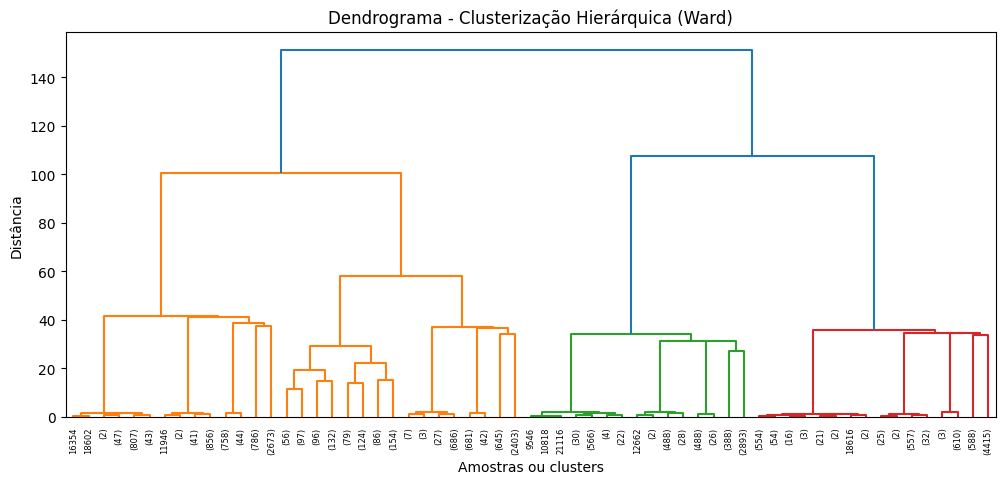

Tipo de X: <class 'numpy.ndarray'>, Formato: (23204, 29)
Tipo de labels_hier: <class 'numpy.ndarray'>, Formato: (23204,)

RESULTADOS FINAIS:
Número de clusters: 3
Silhouette Score: 0.2381
Inércia total: 29166.8811
Cluster 1 - Centróide: [9.19858331e-03 7.95882501e-03 5.33831283e-03 3.40070299e-02
 9.65992970e-01 1.46836555e-01 1.40333919e-01 1.24956063e-01
 1.37346221e-01 9.42882250e-02 7.26713533e-02 7.38137083e-02
 1.05448155e-03 5.86115993e-02 8.78734622e-04 9.66608084e-04
 1.45869947e-02 3.42706503e-03 3.76977153e-02 3.19859402e-02
 8.78734622e-05 2.53075571e-02 1.72231986e-02 1.79261863e-02
 4.34446397e-01 5.65553603e-01 9.27592267e-01 3.89279438e-02
 3.34797891e-02]
Cluster 2 - Centróide: [0.00926795 0.00775171 0.00548357 1.         0.         0.0583114
 0.06256327 0.06742256 0.05405953 0.05001012 0.07855841 0.03927921
 0.12654383 0.03178781 0.105082   0.10406965 0.06134845 0.07167443
 0.01882972 0.01093339 0.04798542 0.00627657 0.00364446 0.00161976
 0.         1.         1.    

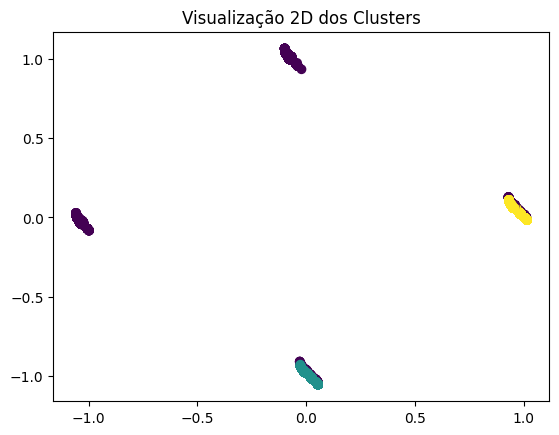

In [6]:

# Cria o linkage e plota o dendrograma
#h_cluster = linkage(X, method='ward')
h_cluster = linkage(X, method='ward')

plt.figure(figsize=(12, 5))
dendrogram(h_cluster, truncate_mode='level', p=5)
plt.title("Dendrograma - Clusterização Hierárquica (Ward)")
plt.xlabel("Amostras ou clusters")
plt.ylabel("Distância")
plt.show()

# 1. Garantir que os dados estejam no formato correto
X = np.asarray(X)  # Converte para array numpy se não for
print(f"Tipo de X: {type(X)}, Formato: {X.shape}")

# 2. Obter os clusters
k_hier = 3
labels_hier = fcluster(h_cluster, k_hier, criterion='maxclust')
labels_hier = np.asarray(labels_hier)  # Garante que seja numpy array
print(f"Tipo de labels_hier: {type(labels_hier)}, Formato: {labels_hier.shape}")

# 3. Cálculo da inércia - abordagem robusta
inertia_hier = 0

for cl in np.unique(labels_hier):
    # Converter para lista de índices se necessário
    mask = (labels_hier == cl)
    cluster_points = X[mask]
    
    # Verificação de segurança
    if len(cluster_points) == 0:
        continue
        
    centroid = np.mean(cluster_points, axis=0)
    inertia_hier += np.sum((cluster_points - centroid) ** 2)

# 4. Cálculo do Silhouette Score
sil_score_hier = silhouette_score(X, labels_hier)

print("\nRESULTADOS FINAIS:")
print(f"Número de clusters: {k_hier}")
print(f"Silhouette Score: {sil_score_hier:.4f}")
print(f"Inércia total: {inertia_hier:.4f}")


for cl in np.unique(labels_hier):
    print(f"Cluster {cl} - Centróide:", X[labels_hier == cl].mean(axis=0))


    
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_hier, cmap='viridis')
plt.title('Visualização 2D dos Clusters')
plt.show()